In [1]:
from torch_geometric.data import Dataset, Data
import random
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch
import networkx as nx
import csv
from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
class SEALDataset(Dataset):
    def __init__(self, graph, pos_edges, neg_edges, h=3):
        super().__init__()
        self.graph = graph
        self.pos_edges = pos_edges
        self.neg_edges = neg_edges
        self.h = h

    def len(self):
        return len(self.pos_edges) + len(self.neg_edges)

    def get(self, idx):
        if idx < len(self.pos_edges):
            u, v = self.pos_edges[idx]
            label = 1
        else:
            u, v = self.neg_edges[idx - len(self.pos_edges)]
            label = 0

        subgraph_nx = extract_enclosing_subgraph(self.graph, u, v, h=self.h)
        data = convert_to_pyg(subgraph_nx)
        data.edge_weight = data.weight
        data.y = torch.tensor(label, dtype=torch.float)
        return data

In [3]:
class SEALGNN(torch.nn.Module):
    def __init__(self, num_labels, hidden_dim=64, dropout_rate=0.5):
        super().__init__()
        self.label_emb = torch.nn.Embedding(num_labels, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x = self.label_emb(data.x)
        x = self.conv1(x, data.edge_index, data.edge_weight).relu()
        x = self.dropout(x)
        x = self.conv2(x, data.edge_index, data.edge_weight).relu()
        x = self.dropout(x)
        x = global_mean_pool(x, data.batch)
        return self.mlp(x).squeeze()

In [4]:
def drnl_node_labeling(subgraph, u, v):
    dist_u = nx.single_source_shortest_path_length(subgraph, u)
    dist_v = nx.single_source_shortest_path_length(subgraph, v)
    
    labels = {}
    for node in subgraph.nodes():
        d1 = dist_u.get(node, 1e6)
        d2 = dist_v.get(node, 1e6)
        if d1 + d2 == 0:
            label = 0
        else:
            label = 1 + min(d1, d2) + ((d1 + d2) * (d1 + d2 + 1)) // 2
        labels[node] = label

    nx.set_node_attributes(subgraph, labels, "x")  # PYG will treat 'x' as node feature
    return subgraph

In [5]:
def extract_enclosing_subgraph(graph, u, v, h=3, top_k=5):
    def bfs_topk(node, h, k):
        visited = set()
        queue = [(node, 0)]
        collected = set([node])

        while queue:
            current, depth = queue.pop(0)
            if depth >= h:
                continue

            # Get neighbors sorted by descending weight
            neighbors = sorted(
                graph[current].items(),
                key=lambda x: x[1].get('weight', 1.0),
                reverse=True
            )
            # Take top-k neighbors only
            for neighbor, _ in neighbors[:k]:
                if neighbor not in visited:
                    visited.add(neighbor)
                    collected.add(neighbor)
                    queue.append((neighbor, depth + 1))
        return collected

    # Get truncated neighborhoods from u and v
    nodes_u = bfs_topk(u, h, top_k)
    nodes_v = bfs_topk(v, h, top_k)

    # Combine nodes and extract subgraph
    nodes = nodes_u.union(nodes_v)
    subgraph = graph.subgraph(nodes).copy()

    # Apply DRNL labeling
    return drnl_node_labeling(subgraph, u, v)


In [6]:
def generate_pos_neg_edges(graph, ratio=1.0):
    pos_edges = list(graph.edges())
    non_edges = [(u, v) for u, v in nx.non_edges(G) if nx.has_path(G, u, v) and nx.shortest_path_length(G, u, v) <= 2]
    
    num_pos = len(pos_edges)
    num_neg = min(int(num_pos * ratio), len(non_edges))  # Prevent oversampling
    
    neg_edges = random.sample(non_edges, num_neg)
    return pos_edges, neg_edges

In [7]:
def convert_to_pyg(subgraph, min_edge_weight=0.01):
    # Assign default edge weight if missing
    for u, v in subgraph.edges():
        if 'weight' not in subgraph[u][v]:
            subgraph[u][v]['weight'] = 1.0

    # Map nodes to consecutive integers starting from 0
    node_mapping = {node: idx for idx, node in enumerate(subgraph.nodes())}
    subgraph = nx.relabel_nodes(subgraph, node_mapping)

    # Collect edge weights (in new node index space)
    edge_weights = [
        max(subgraph[u][v]['weight'], min_edge_weight)
        for u, v in subgraph.edges()
    ]

    # Convert to PyG data
    data = from_networkx(subgraph)

    # Use DRNL label or raw index as features — safe because of remap
    data.x = torch.arange(data.num_nodes, dtype=torch.long)  # or: torch.tensor([node for node in range(data.num_nodes)])

    # Assign edge weights
    data.edge_weight = torch.tensor(edge_weights, dtype=torch.float)

    return data

In [31]:
import matplotlib.pyplot as plt

def train_seal_model(graph, h=3, num_epochs=10):
    pos_edges, neg_edges = generate_pos_neg_edges(graph)

    # Split each into train and test sets
    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2, random_state=42)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2, random_state=42)

    # Create train dataset and loader
    train_dataset = SEALDataset(graph, pos_train, neg_train, h=h)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    smooth_pos = 0.97
    smooth_neg = 0.03

    model = SEALGNN(num_labels=300)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Store epoch losses for plotting
    epoch_losses = []

    # --- Training ---
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            batch_y_smoothed = batch.y.float() * smooth_pos + (1 - batch.y.float()) * smooth_neg
            loss = criterion(out, batch_y_smoothed)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

    # --- Plot the loss curve ---
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Evaluation ---
    model.eval()
    test_dataset = SEALDataset(graph, pos_test, neg_test, h=h)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            logits = model(batch)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()

            all_preds.extend(preds.tolist())
            all_probs.extend(probs.tolist())
            all_labels.extend(batch.y.tolist())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test ROC-AUC:  {roc_auc:.4f}")

    return model

In [15]:
G = nx.Graph()

with open("graph_data.csv", "r") as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for topic1, topic2, weight in reader:
        G.add_edge(int(topic1), int(topic2), weight=float(weight))

print("Graph loaded from CSV")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print("Edges with weights:")
for u, v, w in G.edges(data=True):
    print(f"{u} - {v} (weight: {w['weight']})")

Graph loaded from CSV
Number of nodes: 129
Number of edges: 2352
Edges with weights:
7 - 80 (weight: 1.0)
7 - 49 (weight: 1.0)
7 - 24 (weight: 1.0)
7 - 71 (weight: 8.0)
7 - 61 (weight: 2.0)
7 - 79 (weight: 4.0)
7 - 21 (weight: 2.0)
7 - 128 (weight: 2.0)
7 - 120 (weight: 2.0)
7 - 91 (weight: 2.0)
7 - 92 (weight: 2.0)
7 - 22 (weight: 2.0)
7 - 76 (weight: 2.0)
7 - 59 (weight: 2.0)
7 - 26 (weight: 2.0)
7 - 23 (weight: 4.0)
7 - 114 (weight: 2.0)
7 - 98 (weight: 2.0)
7 - 33 (weight: 2.0)
7 - 94 (weight: 2.0)
7 - 93 (weight: 2.0)
7 - 29 (weight: 2.0)
7 - 104 (weight: 2.0)
7 - 108 (weight: 2.0)
7 - 107 (weight: 2.0)
7 - 95 (weight: 2.0)
7 - 99 (weight: 2.0)
7 - 38 (weight: 2.0)
7 - 129 (weight: 2.0)
7 - 74 (weight: 2.0)
80 - 18 (weight: 1.0)
80 - 55 (weight: 2.0)
80 - 122 (weight: 2.0)
80 - 25 (weight: 2.0)
80 - 87 (weight: 2.0)
80 - 67 (weight: 2.0)
80 - 31 (weight: 2.0)
80 - 77 (weight: 2.0)
80 - 112 (weight: 2.0)
80 - 44 (weight: 2.0)
80 - 96 (weight: 2.0)
80 - 102 (weight: 2.0)
80 - 83 (we

In [16]:
sgraph = extract_enclosing_subgraph(G,4,9)
print("Graph loaded from CSV")
print(f"Number of nodes: {sgraph.number_of_nodes()}")
print(f"Number of edges: {sgraph.number_of_edges()}")
print("Edges with weights:")
print(convert_to_pyg(sgraph))

Graph loaded from CSV
Number of nodes: 24
Number of edges: 148
Edges with weights:
Data(x=[24], edge_index=[2, 296], weight=[296], edge_weight=[148])


Epoch 1, Loss: 0.5801
Epoch 2, Loss: 0.4942
Epoch 3, Loss: 0.4738
Epoch 4, Loss: 0.4545
Epoch 5, Loss: 0.4416
Epoch 6, Loss: 0.4356
Epoch 7, Loss: 0.4225
Epoch 8, Loss: 0.4194
Epoch 9, Loss: 0.4083
Epoch 10, Loss: 0.4041


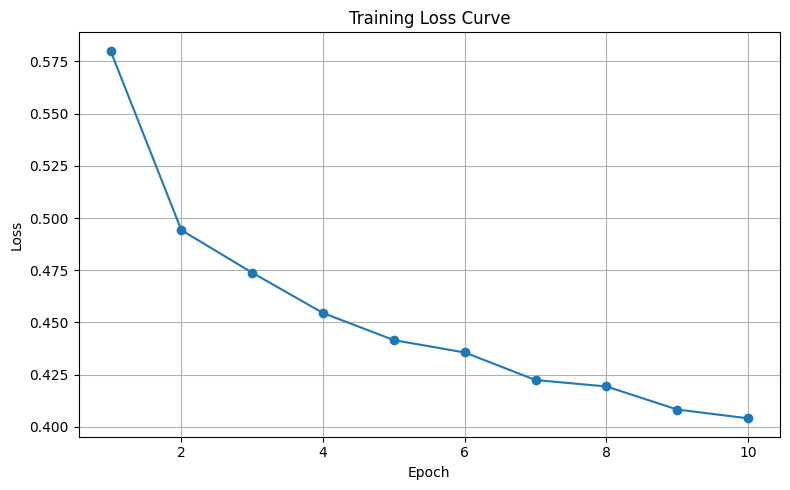

Test Accuracy: 0.8471
Test ROC-AUC:  0.9295


In [32]:
#train model using graph data

model = train_seal_model(G)

In [26]:
def predict_link_score(model, graph, u, v, h=3, device='cpu'):
    subgraph_nx = extract_enclosing_subgraph(graph, u, v, h)
    data = convert_to_pyg(subgraph_nx)
    data.edge_weight = data.weight  # pass edge weights to GCNConv
    data = data.to(device)
    data.batch = torch.zeros(data.num_nodes, dtype=torch.long, device=device)  # single graph
    
    model.eval()
    with torch.no_grad():
        score = model(data).item()
    return score

In [28]:
score = predict_link_score(
    model=model,
    graph=G,
    u=85,
    v=56,
    h=3
)
prob = torch.sigmoid(torch.tensor(score)).item()
print(f"Predicted score between 1 and 75: {prob}")
print(f"Predicted score between 1 and 75: {score}")

Predicted score between 1 and 75: 0.11991947144269943
Predicted score between 1 and 75: -1.9931929111480713


In [37]:
import torch
import numpy as np
from itertools import combinations

def get_predictions(model, graph, node_pairs):
    """Returns raw scores and probabilities for a list of node pairs."""
    scores, probs = [], []
    for u, v in node_pairs:
        score = predict_link_score(model=model, graph=graph, u=u, v=v, h=3)
        prob = torch.sigmoid(torch.tensor(score)).item()
        scores.append(score)
        probs.append(prob)
    return np.array(scores), np.array(probs)

# Example: Random node pairs (replace with your graph's nodes)
nodes = list(G.nodes())
node_pairs = list(combinations(np.random.choice(nodes, size=100, replace=False), 2))

# Get predictions
scores_after, probs_after = get_predictions(model, G, node_pairs)    # After fixes

In [33]:
scores_before, probs_before = get_predictions(model, G, node_pairs)  # Before fixes

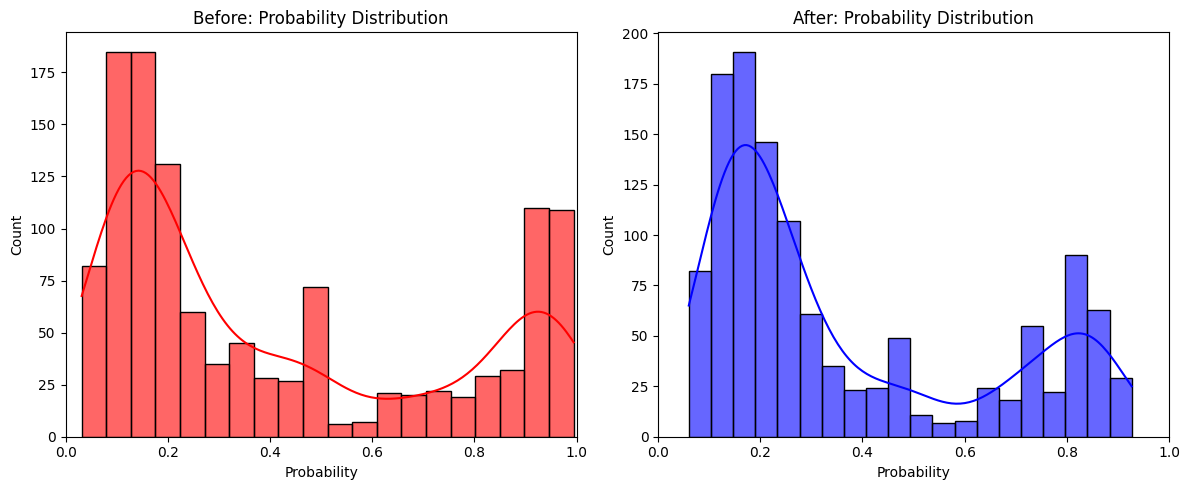

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Before fixes (overconfident)
plt.subplot(1, 2, 1)
sns.histplot(probs_before, bins=20, kde=True, color='red', alpha=0.6)
plt.title("Before: Probability Distribution")
plt.xlabel("Probability")
plt.xlim(0, 1)

# After fixes (calibrated)
plt.subplot(1, 2, 2)
sns.histplot(probs_after, bins=20, kde=True, color='blue', alpha=0.6)
plt.title("After: Probability Distribution")
plt.xlabel("Probability")
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

In [18]:
#save model
torch.save({
    'state_dict': model.state_dict(),
    'num_labels': 300,
    'hidden_dim': 64,
}, "seal_model.pt")